# Sales & Demand Forecasting (Future Interns – Task 1)

Dataset: Sample – Superstore (orders from 2014–2017)  



# ARIMA, SARIMA and SARIMAX — Superstore Daily Sales




In [4]:
# If running in a fresh environment, install common libs (uncomment if needed)
# !pip -q install pandas numpy matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
# Load Pandas
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


In [6]:
DATA_PATH = r"/content/Sample - Superstore.csv"

df = pd.read_csv(DATA_PATH, encoding_errors="ignore")
print("Rows, Cols:", df.shape)
df.head()


Rows, Cols: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [7]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def model_assessment(train_series, test_series, preds, title):
    mae = mean_absolute_error(test_series, preds)
    r = rmse(test_series, preds)
    mape = mean_absolute_percentage_error(test_series, preds)

    print(f"{title} — Test metrics")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {r:,.2f}")
    print(f"MAPE: {mape:.4f}")

    plt.figure(figsize=(12,5))
    train_series.plot(label="Train")
    test_series.plot(label="Test")
    preds.plot(label="Forecast")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_future(history, future_forecast, title):
    plt.figure(figsize=(12,5))
    history.plot(label="History")
    future_forecast.plot(label="Forecast")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Libraries and Data




In [8]:
df_raw = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")
df_raw["Order Date"] = pd.to_datetime(df_raw["Order Date"])
df_raw.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [9]:
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   object        
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [10]:
daily = (
    df_raw
    .groupby("Order Date")
    .agg(
        y=("Sales", "sum"),
        x_discount=("Discount", "mean"),
        x_quantity=("Quantity", "sum"),
    )
    .sort_index()
)

daily = daily.asfreq("D")
daily["y"] = daily["y"].fillna(0)
daily["x_discount"] = daily["x_discount"].fillna(0)
daily["x_quantity"] = daily["x_quantity"].fillna(0)

daily.head()


,y,x_discount,x_quantity
Order Date,,,
2014-01-03,16.448,0.2,2.0
2014-01-04,288.060,0.4,8.0
2014-01-05,19.536,0.2,3.0
2014-01-06,4407.100,0.0,30.0
2014-01-07,87.158,0.7,10.0


## Exploratory Data Analysis


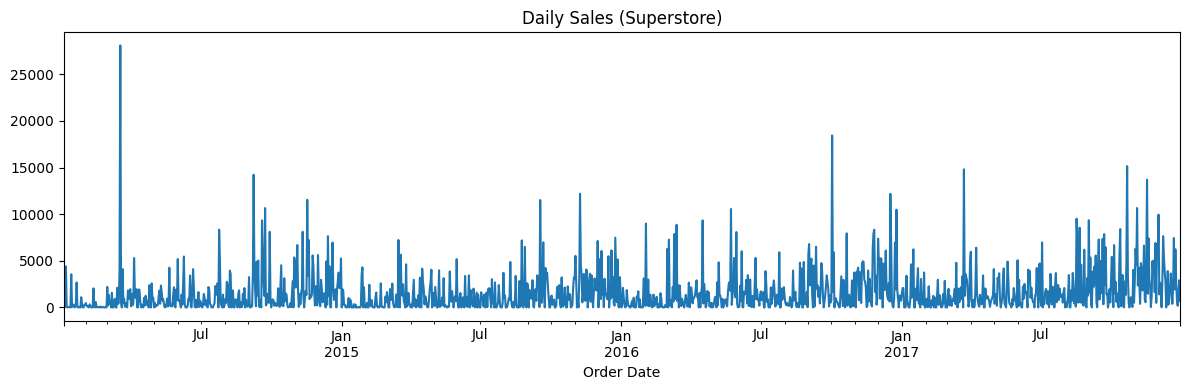

In [11]:
daily["y"].plot(figsize=(12,4), title="Daily Sales (Superstore)")
plt.tight_layout()
plt.show()


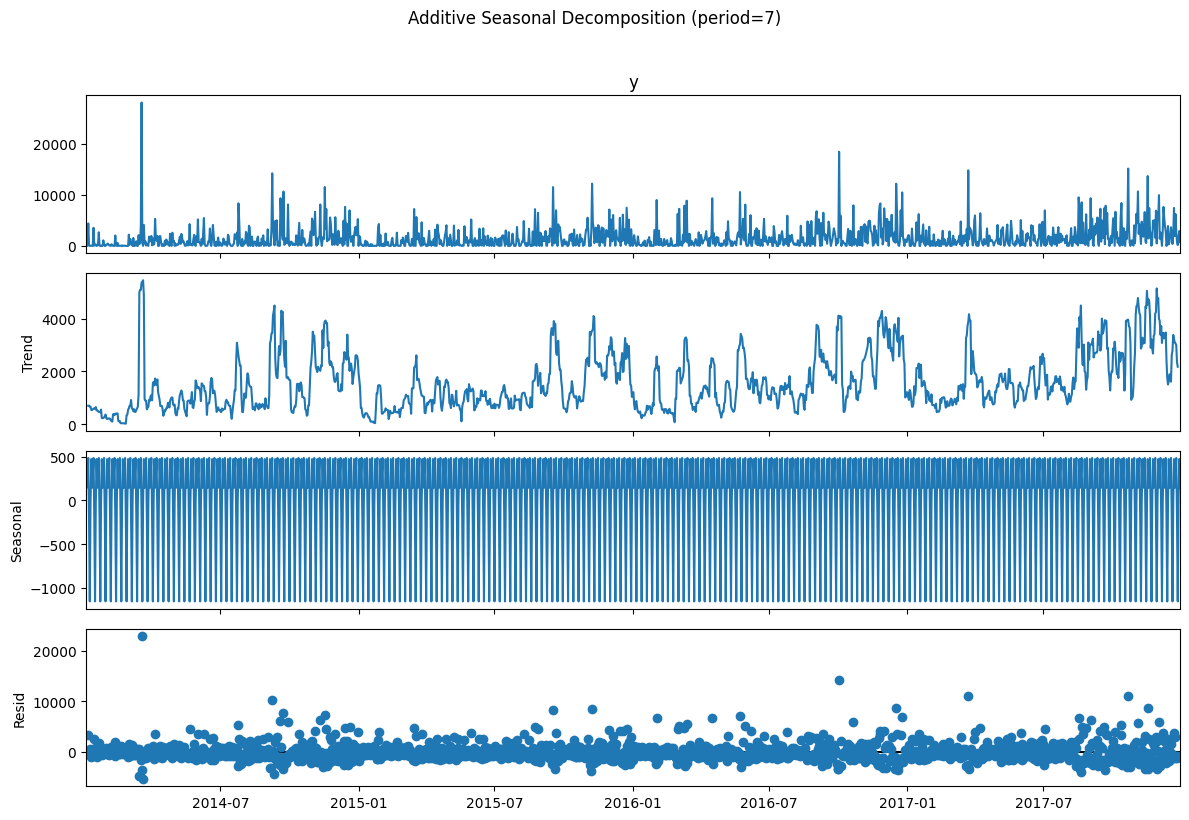

In [12]:
# Decomposition: weekly seasonality is common for daily retail series (period=7)
decomp = seasonal_decompose(daily["y"], model="additive", period=7)
fig = decomp.plot()
fig.set_size_inches(12,8)
plt.suptitle("Additive Seasonal Decomposition (period=7)", y=1.02)
plt.tight_layout()
plt.show()

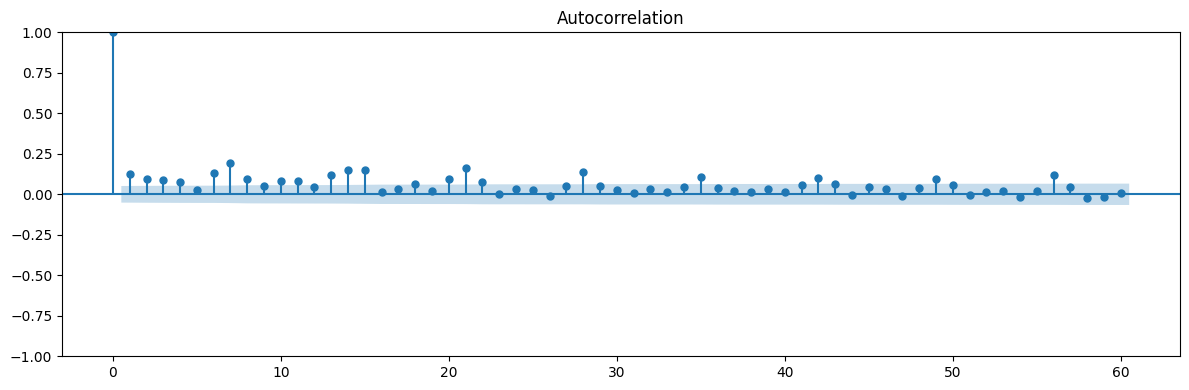

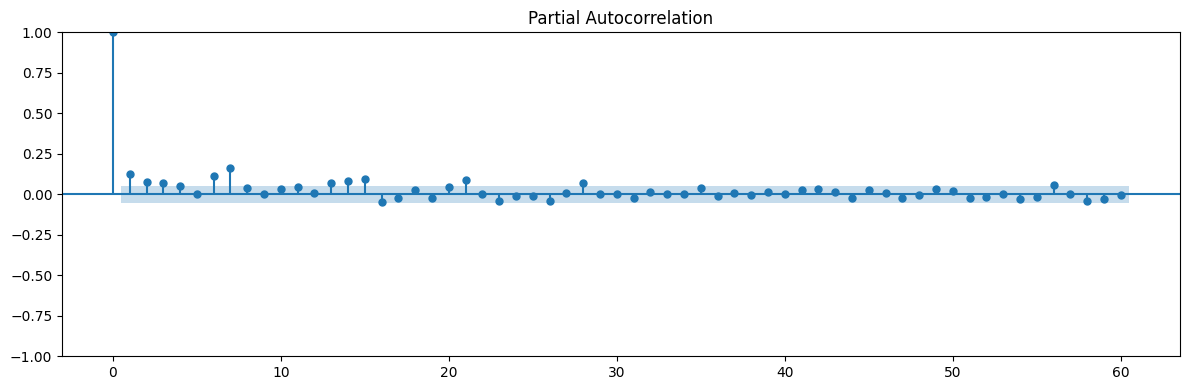

In [13]:
# ACF / PACF (60 lags)
fig, ax = plt.subplots(figsize=(12,4))
plot_acf(daily["y"], lags=60, ax=ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12,4))
plot_pacf(daily["y"], lags=60, ax=ax, method="ywm")
plt.tight_layout()
plt.show()


## Stationarity (ADF test)




In [14]:
adf = adfuller(daily["y"])
print(f"ADF p-value: {adf[1]:.6f}")

if adf[1] > 0.05:
    print("Not stationary (consider differencing).")
else:
    print("Stationary.")


ADF p-value: 0.000029
Stationary.


In [15]:
daily["y_diff"] = daily["y"].diff()

adf2 = adfuller(daily["y_diff"].dropna())
print(f"ADF p-value after 1st diff: {adf2[1]:.6f}")


ADF p-value after 1st diff: 0.000000


## Train / Test split
Last 30 days kept for evaluation.


In [16]:
test_days = 30
train = daily.iloc[:-test_days].copy()
test = daily.iloc[-test_days:].copy()

train.tail(), test.head()


(                   y  x_discount  x_quantity    y_diff
 Order Date                                            
 2017-11-26  5048.172    0.112500        69.0  1382.015
 2017-11-27  1618.254    0.076923        61.0 -3429.918
 2017-11-28  6912.944    0.116667        65.0  5294.690
 2017-11-29   491.888    0.200000         7.0 -6421.056
 2017-11-30  6645.282    0.133333        60.0  6153.394,
                    y  x_discount  x_quantity    y_diff
 Order Date                                            
 2017-12-01  5331.178    0.152941       149.0 -1314.104
 2017-12-02  9951.182    0.232353       152.0  4620.004
 2017-12-03  1403.842    0.205000        70.0 -8547.340
 2017-12-04  2639.638    0.177778        64.0  1235.796
 2017-12-05  1453.136    0.063158        75.0 -1186.502)

## ARIMA (non-seasonal)


In [17]:
arima = SARIMAX(
    train["y"],
    order=(3,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(arima.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1428
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -12963.157
Date:                Thu, 15 Jan 2026   AIC                          25936.314
Time:                        22:11:59   BIC                          25962.620
Sample:                    01-03-2014   HQIC                         25946.140
                         - 11-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0379      0.032      1.190      0.234      -0.025       0.100
ar.L2          0.0037      0.032      0.116      0.908      -0.059       0.066
ar.L3          0.0054      0.032      0.168      0.8

ARIMA — Test metrics
MAE : 2,145.47
RMSE: 2,556.73
MAPE: 517010115744013696.0000


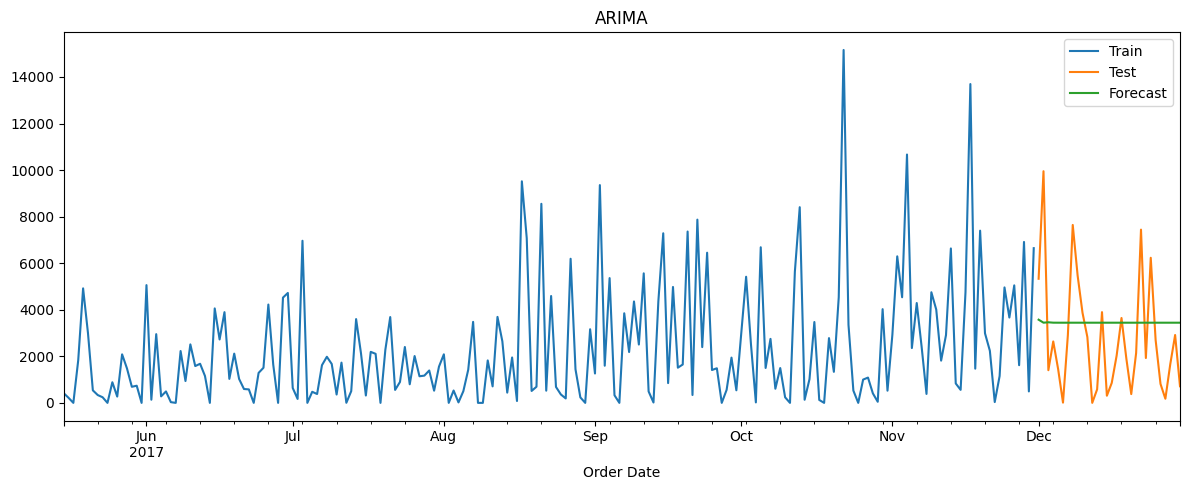

In [18]:
pred_arima = arima.forecast(steps=test_days)
pred_arima.index = test.index

model_assessment(train["y"].iloc[-200:], test["y"], pred_arima, "ARIMA")


## SARIMA (weekly seasonality s=7)


In [19]:
sarima = SARIMAX(
    train["y"],
    order=(3,1,1),
    seasonal_order=(2,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima.summary())


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1428
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -12807.322
Date:                           Thu, 15 Jan 2026   AIC                          25630.643
Time:                                   22:12:07   BIC                          25672.654
Sample:                               01-03-2014   HQIC                         25646.342
                                    - 11-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0283      0.035      0.812      0.417      -0.040       0.097
ar.L2          0.0549      0.032      1.732

SARIMA (s=7) — Test metrics
MAE : 2,041.36
RMSE: 2,351.01
MAPE: 413206229596367680.0000


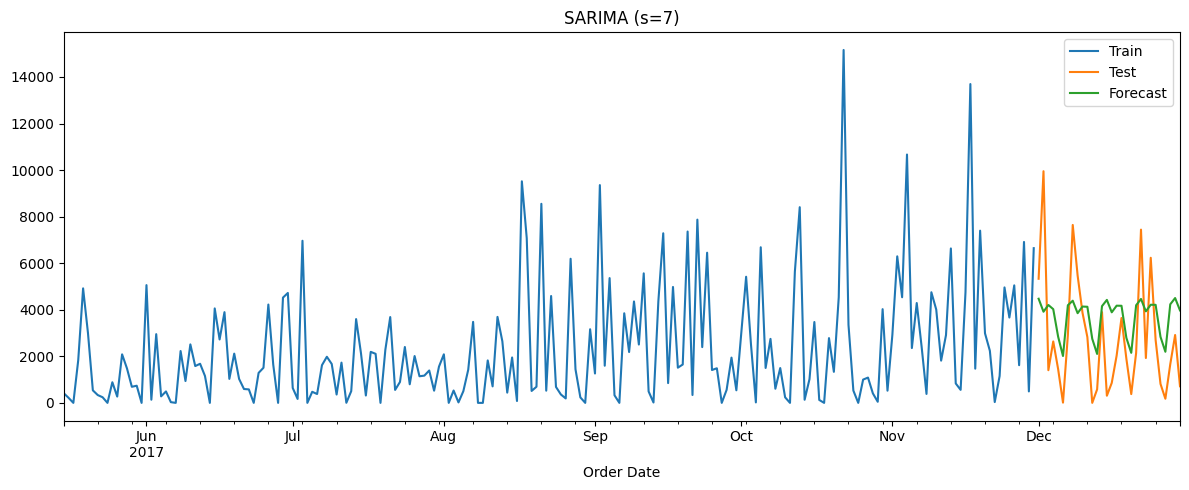

In [20]:
pred_sarima = sarima.forecast(steps=test_days)
pred_sarima.index = test.index

model_assessment(train["y"].iloc[-200:], test["y"], pred_sarima, "SARIMA (s=7)")


## SARIMAX (with exogenous variables)



In [21]:
train_exog = train[["x_discount", "x_quantity"]]
test_exog = test[["x_discount", "x_quantity"]]

sarimax = SARIMAX(
    train["y"],
    exog=train_exog,
    order=(3,1,1),
    seasonal_order=(2,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarimax.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1428
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -12438.652
Date:                           Thu, 15 Jan 2026   AIC                          24897.305
Time:                                   22:12:19   BIC                          24949.818
Sample:                               01-03-2014   HQIC                         24916.928
                                    - 11-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_discount  -756.3043    656.670     -1.152      0.249   -2043.353     530.745
x_quantity    61.4882      1.981     31.038

SARIMAX (discount + quantity) — Test metrics
MAE : 1,224.58
RMSE: 1,584.76
MAPE: 12746078320686978.0000


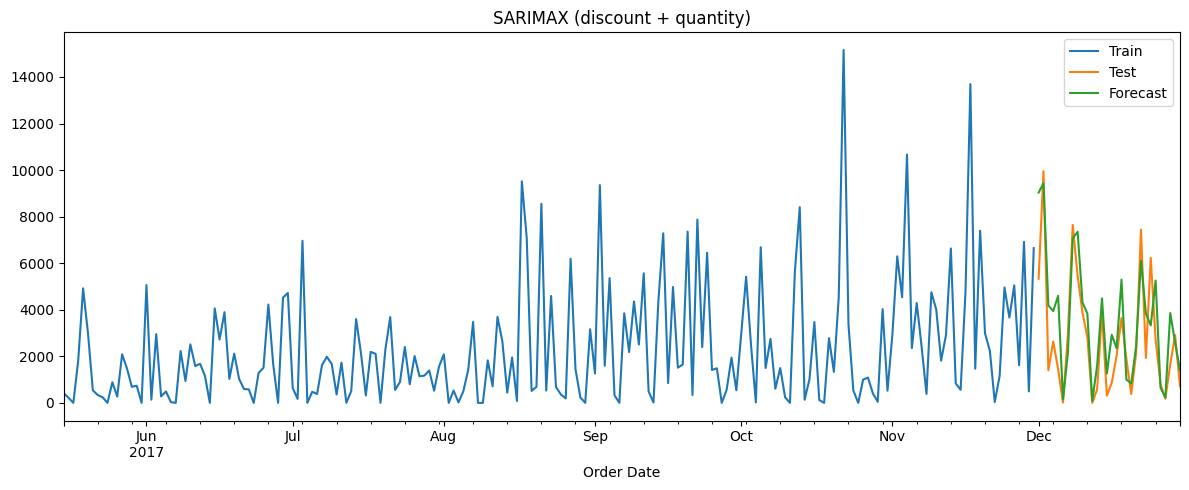

In [22]:
pred_sarimax = sarimax.forecast(steps=test_days, exog=test_exog)
pred_sarimax.index = test.index

model_assessment(train["y"].iloc[-200:], test["y"], pred_sarimax, "SARIMAX (discount + quantity)")


## Cross‑validation (forward chaining)


In [23]:
order = (3,1,1)
seasonal_order = (2,0,1,7)
n_splits = 5

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_days)
scores = []

for fold, (tr_idx, te_idx) in enumerate(tscv.split(daily), start=1):
    tr = daily.iloc[tr_idx]
    te = daily.iloc[te_idx]

    tr_exog = tr[["x_discount", "x_quantity"]]
    te_exog = te[["x_discount", "x_quantity"]]

    m = SARIMAX(
        tr["y"],
        exog=tr_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    p = m.forecast(steps=len(te), exog=te_exog)
    p.index = te.index

    scores.append({
        "fold": fold,
        "rmse": rmse(te["y"], p),
        "mae": mean_absolute_error(te["y"], p),
        "mape": mean_absolute_percentage_error(te["y"], p),
    })

cv_scores = pd.DataFrame(scores).set_index("fold")
cv_scores


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,rmse,mae,mape
fold,,,
1,1483.058710,936.689945,4.884744e+16
2,1480.531116,1202.559114,3.143601e+16
3,2584.679380,1276.926874,4.063659e+16
4,2702.963817,1730.045595,9.581001e-01
5,1584.764672,1224.580205,1.274608e+16


In [24]:
print(f"Average RMSE: {cv_scores['rmse'].mean():,.2f}")
print(f"Average MAE : {cv_scores['mae'].mean():,.2f}")
print(f"Average MAPE: {cv_scores['mape'].mean():.4f}")


Average RMSE: 1,967.20
Average MAE : 1,274.16
Average MAPE: 26733222463714016.0000


## Parameter tuning (small grid)


In [25]:
param_grid = {
    "p": [1, 2, 3],
    "d": [1],
    "q": [0, 1],
    "P": [0, 1, 2],
    "D": [0],
    "Q": [0, 1],
}
grid = list(ParameterGrid(param_grid))
len(grid)


36

In [26]:
tscv = TimeSeriesSplit(n_splits=4, test_size=test_days)
rmse_list = []

for params in grid:
    fold_rmse = []

    for tr_idx, te_idx in tscv.split(daily):
        tr = daily.iloc[tr_idx]
        te = daily.iloc[te_idx]

        tr_exog = tr[["x_discount", "x_quantity"]]
        te_exog = te[["x_discount", "x_quantity"]]

        m = SARIMAX(
            tr["y"],
            exog=tr_exog,
            order=(params["p"], params["d"], params["q"]),
            seasonal_order=(params["P"], params["D"], params["Q"], 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        p = m.forecast(steps=len(te), exog=te_exog)
        p.index = te.index
        fold_rmse.append(rmse(te["y"], p))

    rmse_list.append(float(np.mean(fold_rmse)))

rmse_df = pd.DataFrame(grid)
rmse_df["rmse"] = rmse_list
rmse_df.sort_values("rmse").head(10)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,D,P,Q,d,p,q,rmse
29,0,2,0,1,3,1,2078.549246
21,0,1,1,1,2,1,2081.563165
33,0,2,1,1,2,1,2081.718900
5,0,0,0,1,3,1,2082.574541
15,0,1,0,1,2,1,2082.973717
19,0,1,1,1,1,1,2083.817267
25,0,2,0,1,1,1,2084.382507
9,0,0,1,1,2,1,2085.661192
7,0,0,1,1,1,1,2086.296461
13,0,1,0,1,1,1,2087.519650


In [27]:
best_params = rmse_df.loc[rmse_df["rmse"].idxmin()]
best_params


,29
D,0.000000
P,2.000000
Q,0.000000
d,1.000000
p,3.000000
q,1.000000
rmse,2078.549246


## Forecasting the next 30 days



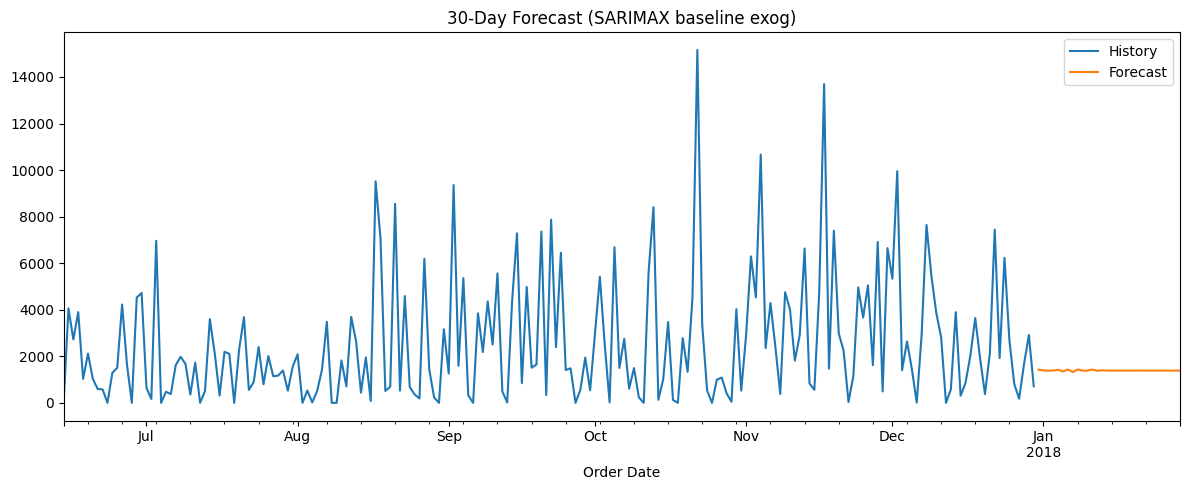

In [28]:
horizon = 30
last_day = daily.index.max()
future_idx = pd.date_range(last_day + pd.Timedelta(days=1), periods=horizon, freq="D")

last_discount = float(daily["x_discount"].iloc[-1])
last_quantity = float(daily["x_quantity"].iloc[-1])

future_exog = pd.DataFrame(
    {"x_discount": [last_discount]*horizon, "x_quantity": [last_quantity]*horizon},
    index=future_idx
)

p = int(best_params["p"]); d = int(best_params["d"]); q = int(best_params["q"])
P = int(best_params["P"]); D = int(best_params["D"]); Q = int(best_params["Q"])

final_model = SARIMAX(
    daily["y"],
    exog=daily[["x_discount", "x_quantity"]],
    order=(p,d,q),
    seasonal_order=(P,D,Q,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

future_forecast = final_model.forecast(steps=horizon, exog=future_exog)
future_forecast.index = future_idx

plot_future(daily["y"].iloc[-200:], future_forecast, "30‑Day Forecast (SARIMAX baseline exog)")


In [29]:
out = pd.DataFrame({"date": future_forecast.index, "forecast_sales": future_forecast.values})
out.to_csv("superstore_future_forecast_30d.csv", index=False)
out.head()


,date,forecast_sales
0,2017-12-31,1427.502266
1,2018-01-01,1395.249809
2,2018-01-02,1379.801799
3,2018-01-03,1392.562305
4,2018-01-04,1419.438385


In [31]:
import os
os.makedirs("models", exist_ok=True)

import pickle

# Save the fitted models
with open("models/arima_superstore.pkl", "wb") as f:
    pickle.dump(arima, f)

with open("models/sarima_superstore.pkl", "wb") as f:
    pickle.dump(sarima, f)

with open("models/sarimax_superstore.pkl", "wb") as f:
    pickle.dump(sarimax, f)

with open("models/final_sarimax_best.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("Saved:")
print(" - models/arima_superstore.pkl")
print(" - models/sarima_superstore.pkl")
print(" - models/sarimax_superstore.pkl")
print(" - models/final_sarimax_best.pkl")


Saved:
 - models/arima_superstore.pkl
 - models/sarima_superstore.pkl
 - models/sarimax_superstore.pkl
 - models/final_sarimax_best.pkl
